In [ ]:
import numpy as np
import pandas as pd
import gc
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()
(market_train_df, news_train_df) = env.get_training_data()

Pre process market data

In [ ]:
def market_process(market_train_df):
    
    market_train_df['time'] = market_train_df.time.dt.date
    market_train_df['bartrend'] = market_train_df['close'] / market_train_df['open']
    market_train_df['average'] = (market_train_df['close'] + market_train_df['open'])/2
    market_train_df['pricevolume'] = market_train_df['volume'] * market_train_df['close']
    
    # drop nans or not?
    market_train_df.dropna(axis=0, inplace=True)
    market_train_df.drop('assetName', axis=1, inplace=True)
    
    #market_train_df.columns = pd.Index(["{}_{}".format(e[0], e[1]) for e in market_train_df.columns.tolist()])
    #market_train_df.reset_index(inplace=True)
    # Set datatype to float32
    float_cols = {c: 'float32' for c in market_train_df.columns if c not in ['assetCode', 'time','assetName']}
    
    return market_train_df.astype(float_cols)

In [ ]:
    market_train_df = market_process(market_train_df)

Add new features to market data

In [ ]:
def analysis_get_features(market_data, byday=False, trainInfo=None):
    # for full training set feature creation
    if(not byday):
        # assign uids to each asset 
        uAssestCode = pd.unique(market_data.assetCode)    
        uidList     = np.linspace(1.0, uAssestCode.shape[0], num=uAssestCode.shape[0])

        # feature 0 - map from assetCode to uid    
        uidMap = {}
        for A, B in zip(uAssestCode, uidList):
            uidMap[A] = B

        aUID = np.zeros(market_data.shape[0])
        for i, item in enumerate(market_data.assetCode):
            aUID[i] = uidMap[item]

        # feature 1, 2 - gain, gainb    
        gain  = market_data.close - market_data.open    
        gainb = np.zeros(gain.shape[0])
        # classify
        gainb[gain > 0] = 1

        # feature 3 - volumeb
        v   = market_data.volume
        npv = np.array(v)    
        vbins, ved = np.histogram(v, bins=20)
        volumeb    = np.zeros(v.shape[0])

        # create classes for bins
        for i in range(1, ved.shape[0] - 1): 
            volumeb[np.logical_and(ved[i] < npv, npv < ved[i+1])] = i

        # features to dataframe
        #Xdict = {1: aUID, 2: gain, 3: gainb, 4: volumeb}
        Xdict = {1: gain, 2: gainb, 3: volumeb}
        X     = pd.DataFrame(Xdict)
        
        # save off training information
        trainInfo = (uidList, uidMap, ved)
        
    # for one off feature creation
    else:                
        # feature 0
        auid = np.zeros(market_data.assetCode.shape[0])
        for i, assetCode in enumerate(market_data.assetCode):
            # look for uid
            if assetCode in trainInfo[1]:
                uid = trainInfo[1][assetCode]
            else:
                # if its a new asset code create a new uid
                newUID = trainInfo[0].max() + 1
                np.append(trainInfo[0], newUID)
                
                # update dict
                trainInfo[1][assetCode] = newUID
                uid = newUID
                
            # set uid
            auid[i] = uid
        
        # feature 1, 2 - gain, gainb
        gain  = market_data.close - market_data.open    
        gainb = np.zeros(gain.shape[0])
        # classify
        gainb[gain > 0] = 1
        
        # feature 3 - volumeb
        v   = market_data.volume
        npv = np.array(v)    
        # TODO consider using the same bin alignment as the training data
        # it may be better to leave it as-is; it would be proportionate
        # ved = trainInfo[2][i]
        vbins, ved = np.histogram(v, bins=20)
        volumeb    = np.zeros(v.shape[0])

        # create classes for bins
        for i in range(1, ved.shape[0] - 1): 
            volumeb[np.logical_and(ved[i] < npv, npv < ved[i+1])] = i
                
        # features to dataframe
        #Xdict = {1: auid, 2: gain, 3: gainb, 4: volumeb}
        Xdict = {1: gain, 2: gainb, 3: volumeb}
        X     = pd.DataFrame(Xdict)
    
    return X, trainInfo

In [ ]:
features, trainInfo = analysis_get_features(market_train_df)
#features.shape: (3979902, 3)
#3 new features created from the existing data
#start looking at Andrew's code from Training function

Merge the new features to market_train_df

In [ ]:
#New column names to be gain gainb volumeb
market_train_df = market_train_df.assign(gain=features[1].values, gainb = features[2].values, volumeb = features[3].values)


Pre processing news data

In [ ]:
def news_process(news_train_df):
    
    news_train_df['time'] = news_train_df.time.dt.date
    news_train_df['position'] = news_train_df['firstMentionSentence'] / news_train_df['sentenceCount']
    news_train_df['coverage'] = news_train_df['sentimentWordCount'] / news_train_df['wordCount']
    droplist = ['sourceTimestamp','firstCreated','sourceId','headline','takeSequence','provider',
            'firstMentionSentence','headlineTag','marketCommentary','subjects','audiences',
            'assetName','noveltyCount12H','noveltyCount24H','noveltyCount3D','noveltyCount5D',
            'noveltyCount7D','urgency','sentimentClass']
    news_train_df.drop(droplist, axis=1, inplace=True)
    
    # Factorize categorical columns
#     for col in ['headlineTag', 'provider', 'sourceId']:
#         news_train[col], uniques = pd.factorize(news_train[col])
#         del uniques
    
    # Remove {} and '' from assetCodes column
    news_train_df['assetCodes'] = news_train_df['assetCodes'].apply(lambda x: x[1:-1].replace("'", ""))
    return news_train_df

In [ ]:
news_train_df = news_process(news_train_df)
#news_train_df.shape(9328750, 35)

In [ ]:
def unstack_asset_codes(news_train_df):
    codes = []
    indexes = []
    for i, values in news_train_df['assetCodes'].iteritems():
        explode = values.split(", ")
        codes.extend(explode)
        repeat_index = [int(i)]*len(explode)
        indexes.extend(repeat_index)
    index_df = pd.DataFrame({'news_index': indexes, 'assetCode': codes})
    del codes, indexes
    gc.collect()
    return index_df

index_df = unstack_asset_codes(news_train_df)

In [ ]:
def merge_news_on_index(news_train_df, index_df):
    news_train_df['news_index'] = news_train_df.index.copy()

    # Merge news on unstacked assets
    news_unstack_df = index_df.merge(news_train_df, how='left', on='news_index')
    news_unstack_df.drop(['news_index', 'assetCodes'], axis=1, inplace=True)
    return news_unstack_df

news_unstack_df = merge_news_on_index(news_train_df, index_df)
del news_train_df, index_df
gc.collect()

In [ ]:
news_unstack_df

In [ ]:
def group_news(news_frame):
    
    aggregations = ['mean']
    gp = news_frame.groupby(['assetCode', 'time']).agg(aggregations)
    gp.columns = pd.Index(["{}_{}".format(e[0], e[1]) for e in gp.columns.tolist()])
    gp.reset_index(inplace=True)
    # Set datatype to float32
    float_cols = {c: 'float32' for c in gp.columns if c not in ['assetCode', 'time']}
    return gp.astype(float_cols)

news_agg_df = group_news(news_unstack_df)
del news_unstack_df; gc.collect()
gc.collect()

In [ ]:
def merge(market_train_df,news_agg_df):
    
    df = market_train_df.merge(news_agg_df, how='left', on=['time','assetCode'])
    # drop nans or not?
    df.dropna(axis=0, inplace=True)
    
    del market_train_df, news_agg_df
    return df

df = merge(market_train_df,news_agg_df)
gc.collect()
#df.shape (1121521, 37)

In [ ]:
time = df.time
num_target = df.returnsOpenNextMktres10.astype('float32')
bin_target = (df.returnsOpenNextMktres10 >= 0).astype('int8')
universe = df.universe.astype('int8')
# Drop columns that are not features
df.drop(['returnsOpenNextMktres10', 'universe', 'assetCode', 'time'], axis=1, inplace=True)
gc.collect()
df.head(3)

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df, bin_target, test_size = 0.20)

In [ ]:
from mlxtend.feature_selection import ColumnSelector

# col_selector = ColumnSelector(cols=('gain','gainb','volumeb'))
# col_selector.fit(X) # optional, does not do anything
# col_selector.transform(X_train)

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

clf1 = LogisticRegression(random_state=1)

In [ ]:
from lightgbm import LGBMClassifier
clf2 = LGBMClassifier(
    objective='binary',
    boosting='gbdt',
    learning_rate = 0.05,
    max_depth = 8,
    num_leaves = 80,
    n_estimators = 400,
    bagging_fraction = 0.8,
    feature_fraction = 0.9)


In [ ]:
# svc linear 
pipe3 = make_pipeline(ColumnSelector(cols=('gain','gainb','volumeb')), MinMaxScaler(),
                      svm.LinearSVC())

In [ ]:
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# for clf in (clf1, clf2):
#     print("Model fit start")
#     clf.fit(X_train, y_train)
#     print("Model fitted")
#     print("------------------------")

In [ ]:
print("Model fit start")
clf1.fit(X_train, y_train)
print("Model fitted")

In [ ]:
y1_pred = clf1.predict(X_test)
print('accuracy Logistic Regression:', np.mean(y_test == y1_pred))
score_1 = f1_score(y1_pred, y_test)
print('f score Logistic Regression:{}'.format(score_1))
# accuracy Logistic Regression: 0.5121909899467243
# f score Logistic Regression:0.5141512366235957

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y1_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Logistic Regression classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
print("Model fit start")
pipe3.fit(X_train, y_train)
print("Model fitted")

In [ ]:
pipe3_pred = pipe3.predict(X_test)
print('accuracy SVC Linear:', np.mean(y_test == pipe3_pred))
score_2 = f1_score(pipe3_pred, y_test)
print('f score SVC Linear:{}'.format(score_2))

# accuracy SVC Linear: 0.5095472682285281
# f score SVC Linear:0.6558187409856991

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pipe3_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for SVC Linear classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
# Train and Test DF without new extracted features
X_train_temp = X_train.loc[:, X_train.columns != 'gain']
X_train_temp = X_train_temp.loc[:, X_train_temp.columns != 'gainb']
X_train_temp = X_train_temp.loc[:, X_train_temp.columns != 'volumeb']
# X_train_temp.columns

In [ ]:
# Train and Test DF without new extracted features
X_test_temp = X_test.loc[:, X_test.columns != 'gain']
X_test_temp = X_test_temp.loc[:, X_test_temp.columns != 'gainb']
X_test_temp = X_test_temp.loc[:, X_test_temp.columns != 'volumeb']
# X_test_temp.columns

In [ ]:
print("Model fit start")
clf2.fit(X_train, y_train)
print("Model fitted")

In [ ]:
y2_pred = clf2.predict(X_test)
print('accuracy LGBM:', np.mean(y_test == y2_pred))
score_2 = f1_score(y2_pred, y_test)
print('f score LGBM:{}'.format(score_2))
# accuracy LGBM: 0.5495374601547001
# f score LGBM:0.5739453100293057

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y2_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for LGBM classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [37]:
from mlxtend.classifier import EnsembleVoteClassifier
import copy
eclf = EnsembleVoteClassifier(clfs=[clf1, pipe3, clf2], weights=[1,2,2], refit = False)

labels = ['Logistic Regression', 'SVC Linear', 'LGBM', 'Ensemble']

eclf.fit(X_train, y_train)
eclfY = eclf.predict(X_test)
print('accuracy ECLF:', np.mean(y_test == eclfY))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy ECLF: 0.5359666525489847


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [38]:
score_eclf = f1_score(eclfY, y_test)
print('f score ECLF:{}'.format(score_eclf))
# LR SVC Ensemble Weight[1,1]
# accuracy ECLF: 0.5128062236686655
# f score ECLF:0.4826296503205159

# LR SVC Ensemble Weight[1,2]
# accuracy ECLF: 0.5095472682285281
# f score ECLF:0.6558187409856991

# LR SVC LGBM Weight[1,2,1]
# accuracy ECLF: 0.5335681326764896
# f score ECLF:0.6030406623134683

# LR SVC LGBM Weight[1,2,2]
# accuracy ECLF: 0.5359666525489847
# f score ECLF:0.6137059511217503

f score ECLF:0.6137059511217503


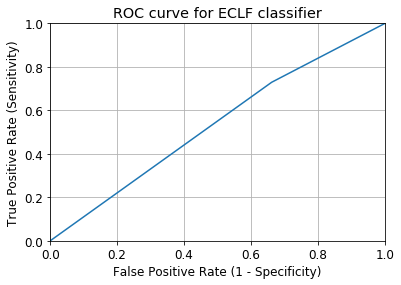

In [39]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, eclfY)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for ECLF classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)